In [1]:
from decimal import Decimal

from uniswap_v3_backtester.algo.pool import Pool, Swap, SwapSeries
from uniswap_v3_backtester.data import run_orm_query


def results_to_swap_series(results, token_0_decimals: int, token_1_decimals: int) -> SwapSeries:
    swaps = []
    for row in results:
        swap, timestamp = row
        swaps.append(Swap(
            timestamp=timestamp,
            tick=swap.tick,
            sqrt_price_x96=Decimal(swap.sqrt_price_x96),
            volume_token0=Decimal(swap.volume_token0) / (10 ** token_0_decimals),
            volume_token1=Decimal(swap.volume_token1) / (10 ** token_1_decimals),
            liquidity=swap.liquidity
        ))
    return SwapSeries(swaps=swaps)


pool_address = "0x149e36e72726e0bcea5c59d40df2c43f60f5a22d"
start = "2021-12-09"
end = "2021-12-21"

token0 = "wbtc"
token0_decimals = 8
token1 = "weth"
token1_decimals = 18

pool = Pool(
    address = pool_address,
    token0 = token0,
    token1=token1,
    fee=Decimal("0.05")
)

results = run_orm_query(pool_address, start, end)
swap_series = results_to_swap_series(results,token0_decimals,token1_decimals)


In [2]:


from uniswap_v3_backtester.algo.math import compute_token1_for_fixed_token0
from uniswap_v3_backtester.algo.pool import Position


amount0 = Decimal("1e8")
current_tick = swap_series.swaps[0].tick
tick_lower = swap_series.swaps[0].tick - 200
tick_upper = swap_series.swaps[0].tick + 400

L, amount1 = compute_token1_for_fixed_token0(amount0, tick_lower, tick_upper, current_tick)


position = Position(tick_lower=tick_lower,tick_upper=tick_upper, amount0=amount0, amount1=amount1, pool=pool, liquidity=L)
created_at = swap_series.swaps[0].timestamp


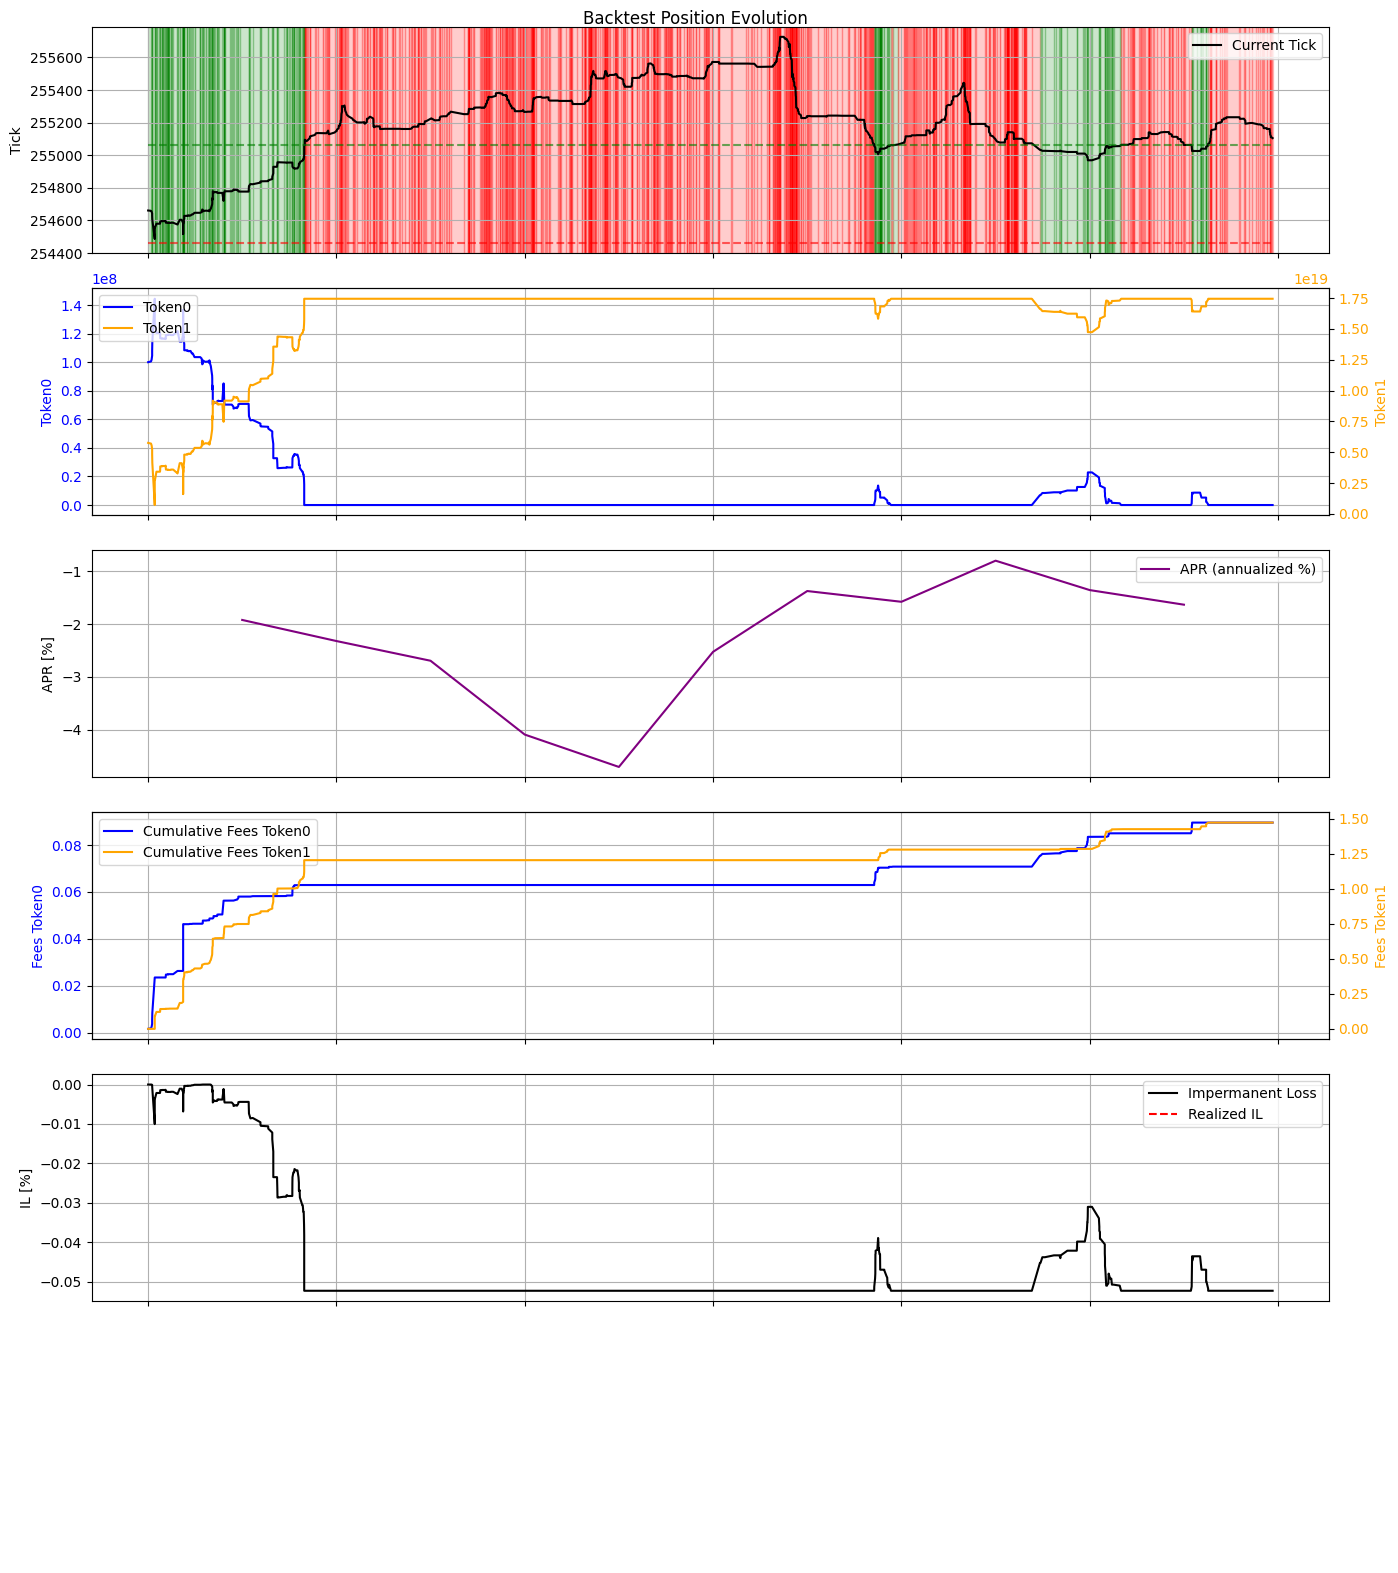

In [3]:

from uniswap_v3_backtester.algo.Impermanent_Loss import ImpermanentLossTracker
from uniswap_v3_backtester.algo.activity import ActivityTracker
from uniswap_v3_backtester.algo.apr import APRTracker
from uniswap_v3_backtester.algo.backtester import GlobalClockBacktestRunner, PositionSimulationContext
from uniswap_v3_backtester.algo.fees import FeeCalculator
from uniswap_v3_backtester.algo.visualization import plot_position_evolution

tracker = ActivityTracker(position=position)
calculator = FeeCalculator(position=position)
il_tracker = ImpermanentLossTracker(
    entry_tick=swap_series.swaps[0].tick,
    entry_token0=position.amount0,
    entry_token1=position.amount1,
    tick_lower=position.tick_lower,
    tick_upper=position.tick_upper
)
apr_tracker = APRTracker(
    initial_token0=position.amount0,
    initial_token1=position.amount1,
    initial_tick=swap_series.swaps[0].tick,
    token0_decimals=token0_decimals,
    token1_decimals=token1_decimals
)
context = PositionSimulationContext(
    position=position,
    created_at=created_at,
    swap_series=swap_series,
    tracker=tracker,
    calculator=calculator,
    il_tracker=il_tracker,
    apr_tracker = apr_tracker
)
runner = GlobalClockBacktestRunner(contexts=[context])
result = runner.run().results[0]


plot_position_evolution(result)

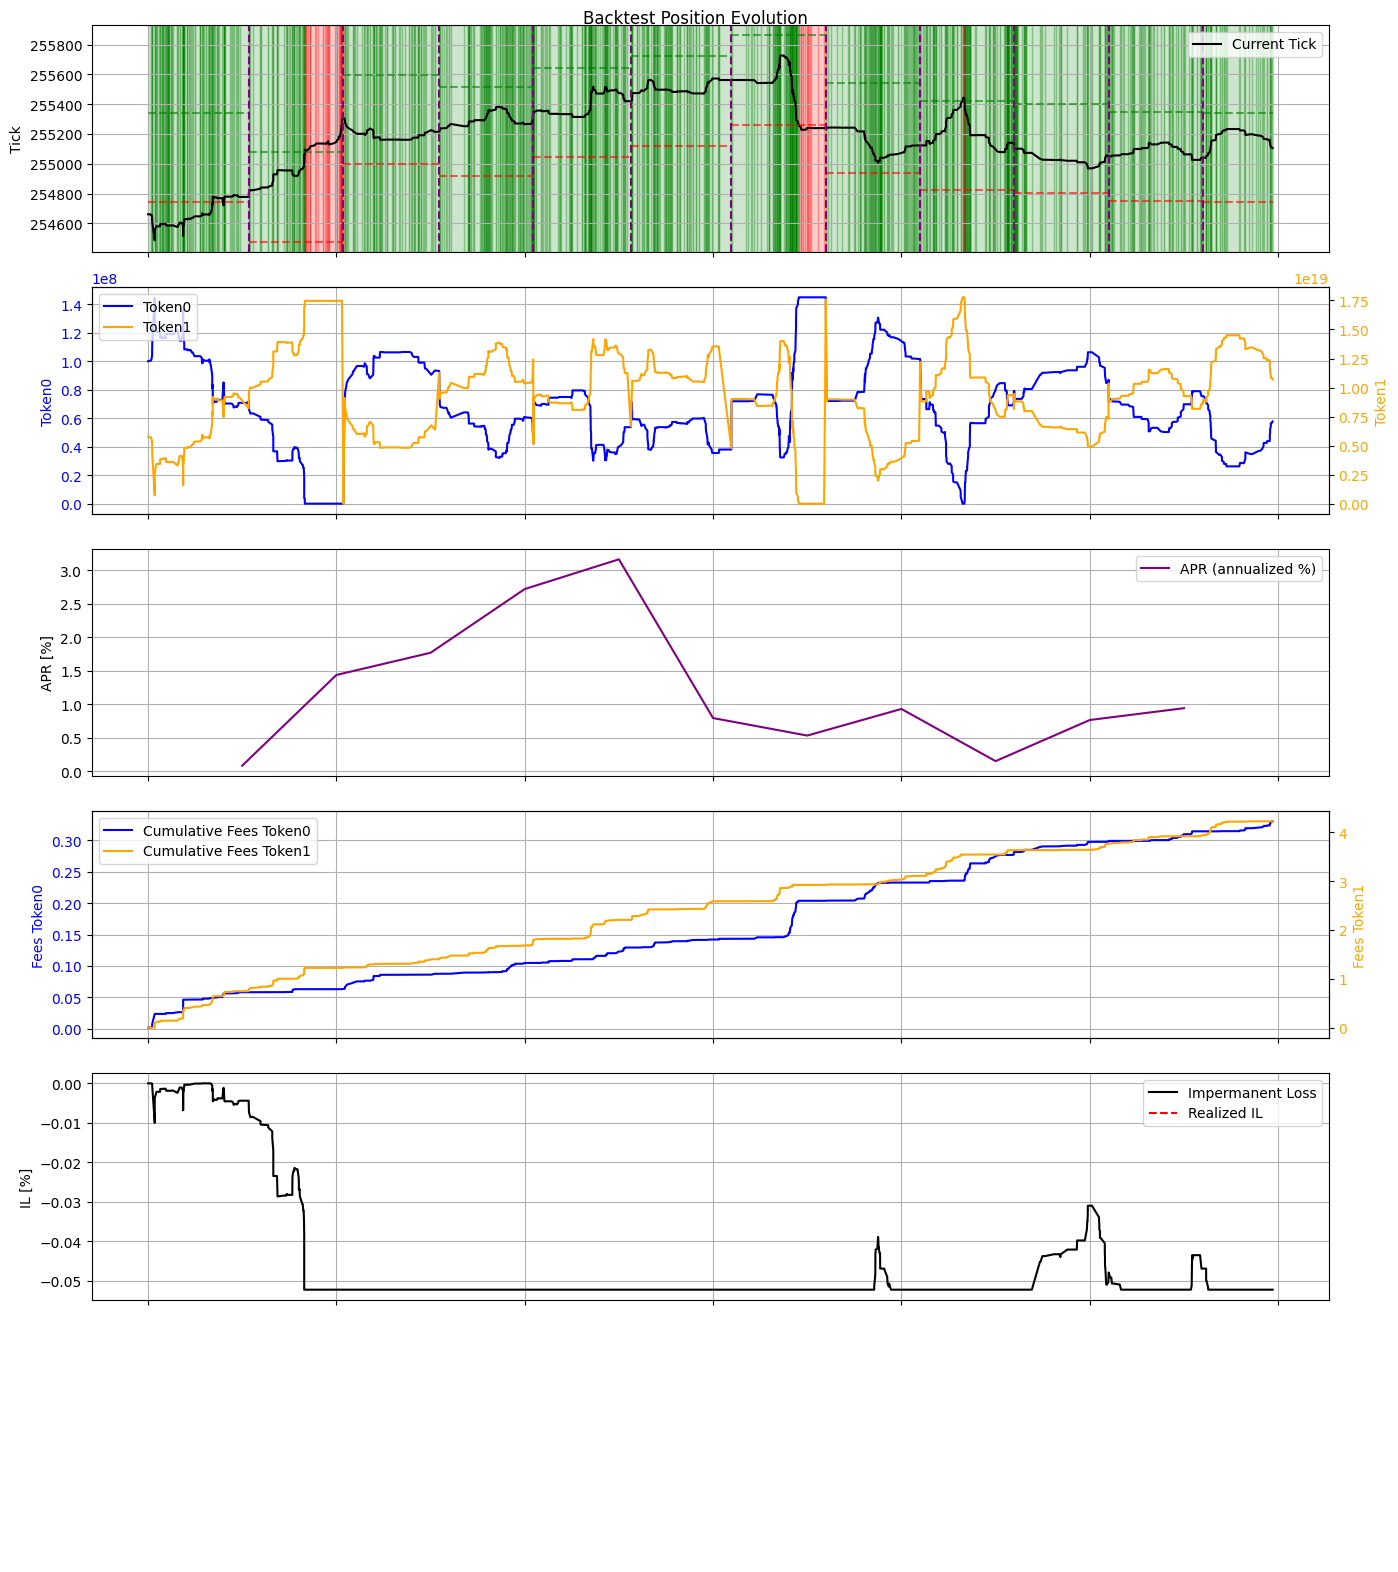

In [4]:
from datetime import timedelta
from uniswap_v3_backtester.algo.rebalancer import TimeTriggeredRebalancer


tracker = ActivityTracker(position=position)
calculator = FeeCalculator(position=position)
il_tracker = ImpermanentLossTracker(
    entry_tick=swap_series.swaps[0].tick,
    entry_token0=position.amount0,
    entry_token1=position.amount1,
    tick_lower=position.tick_lower,
    tick_upper=position.tick_upper
)
apr_tracker = APRTracker(
    initial_token0=position.amount0,
    initial_token1=position.amount1,
    initial_tick=swap_series.swaps[0].tick,
    token0_decimals=token0_decimals,
    token1_decimals=token1_decimals
)
rebalancer = TimeTriggeredRebalancer(interval=timedelta(days=1))
context = PositionSimulationContext(
    position=position,
    created_at=created_at,
    swap_series=swap_series,
    tracker=tracker,
    calculator=calculator,
    il_tracker=il_tracker,
    apr_tracker = apr_tracker,
    rebalancer=rebalancer
)
runner = GlobalClockBacktestRunner(contexts=[context])
result = runner.run().results[0]


plot_position_evolution(result)

In [5]:
from decimal import Decimal
from uniswap_v3_backtester.algo.pool import Position
from uniswap_v3_backtester.algo.backtester import GlobalClockBacktestRunner, PositionSimulationContext
from uniswap_v3_backtester.algo.activity import ActivityTracker
from uniswap_v3_backtester.algo.fees import FeeCalculator
from uniswap_v3_backtester.algo.Impermanent_Loss import ImpermanentLossTracker
from uniswap_v3_backtester.algo.apr import APRTracker

# Shared swap series and pool
initial_tick = swap_series.swaps[0].tick
created_at = swap_series.swaps[0].timestamp

# --------- Position 1 ---------
amount0_p1 = Decimal("1e8")
tick_lower_p1 = initial_tick - 200
tick_upper_p1 = initial_tick + 400
L1, amount1_p1 = compute_token1_for_fixed_token0(amount0_p1, tick_lower_p1, tick_upper_p1, initial_tick)

position1 = Position(tick_lower=tick_lower_p1, tick_upper=tick_upper_p1,
                     amount0=amount0_p1, amount1=amount1_p1,
                     pool=pool, liquidity=L1)

tracker1 = ActivityTracker(position=position1)
calculator1 = FeeCalculator(position=position1)
il_tracker1 = ImpermanentLossTracker(initial_tick, position1.amount0, position1.amount1, tick_lower_p1, tick_upper_p1)
apr_tracker1 = APRTracker(position1.amount0, position1.amount1, initial_tick, token0_decimals, token1_decimals)

context1 = PositionSimulationContext(
    position=position1,
    created_at=created_at,
    swap_series=swap_series,
    tracker=tracker1,
    calculator=calculator1,
    il_tracker=il_tracker1,
    apr_tracker=apr_tracker1
)

# --------- Position 2 (different range) ---------
amount0_p2 = Decimal("1e8")
tick_lower_p2 = initial_tick - 100
tick_upper_p2 = initial_tick + 300
L2, amount1_p2 = compute_token1_for_fixed_token0(amount0_p2, tick_lower_p2, tick_upper_p2, initial_tick)

position2 = Position(tick_lower=tick_lower_p2, tick_upper=tick_upper_p2,
                     amount0=amount0_p2, amount1=amount1_p2,
                     pool=pool, liquidity=L2)

tracker2 = ActivityTracker(position=position2)
calculator2 = FeeCalculator(position=position2)
il_tracker2 = ImpermanentLossTracker(initial_tick, position2.amount0, position2.amount1, tick_lower_p2, tick_upper_p2)
apr_tracker2 = APRTracker(position2.amount0, position2.amount1, initial_tick, token0_decimals, token1_decimals)

context2 = PositionSimulationContext(
    position=position2,
    created_at=created_at,
    swap_series=swap_series,
    tracker=tracker2,
    calculator=calculator2,
    il_tracker=il_tracker2,
    apr_tracker=apr_tracker2
)

# --------- Run the backtest ---------
runner = GlobalClockBacktestRunner(contexts=[context1, context2])
results = runner.run().results

result1 = results[0]
result2 = results[1]


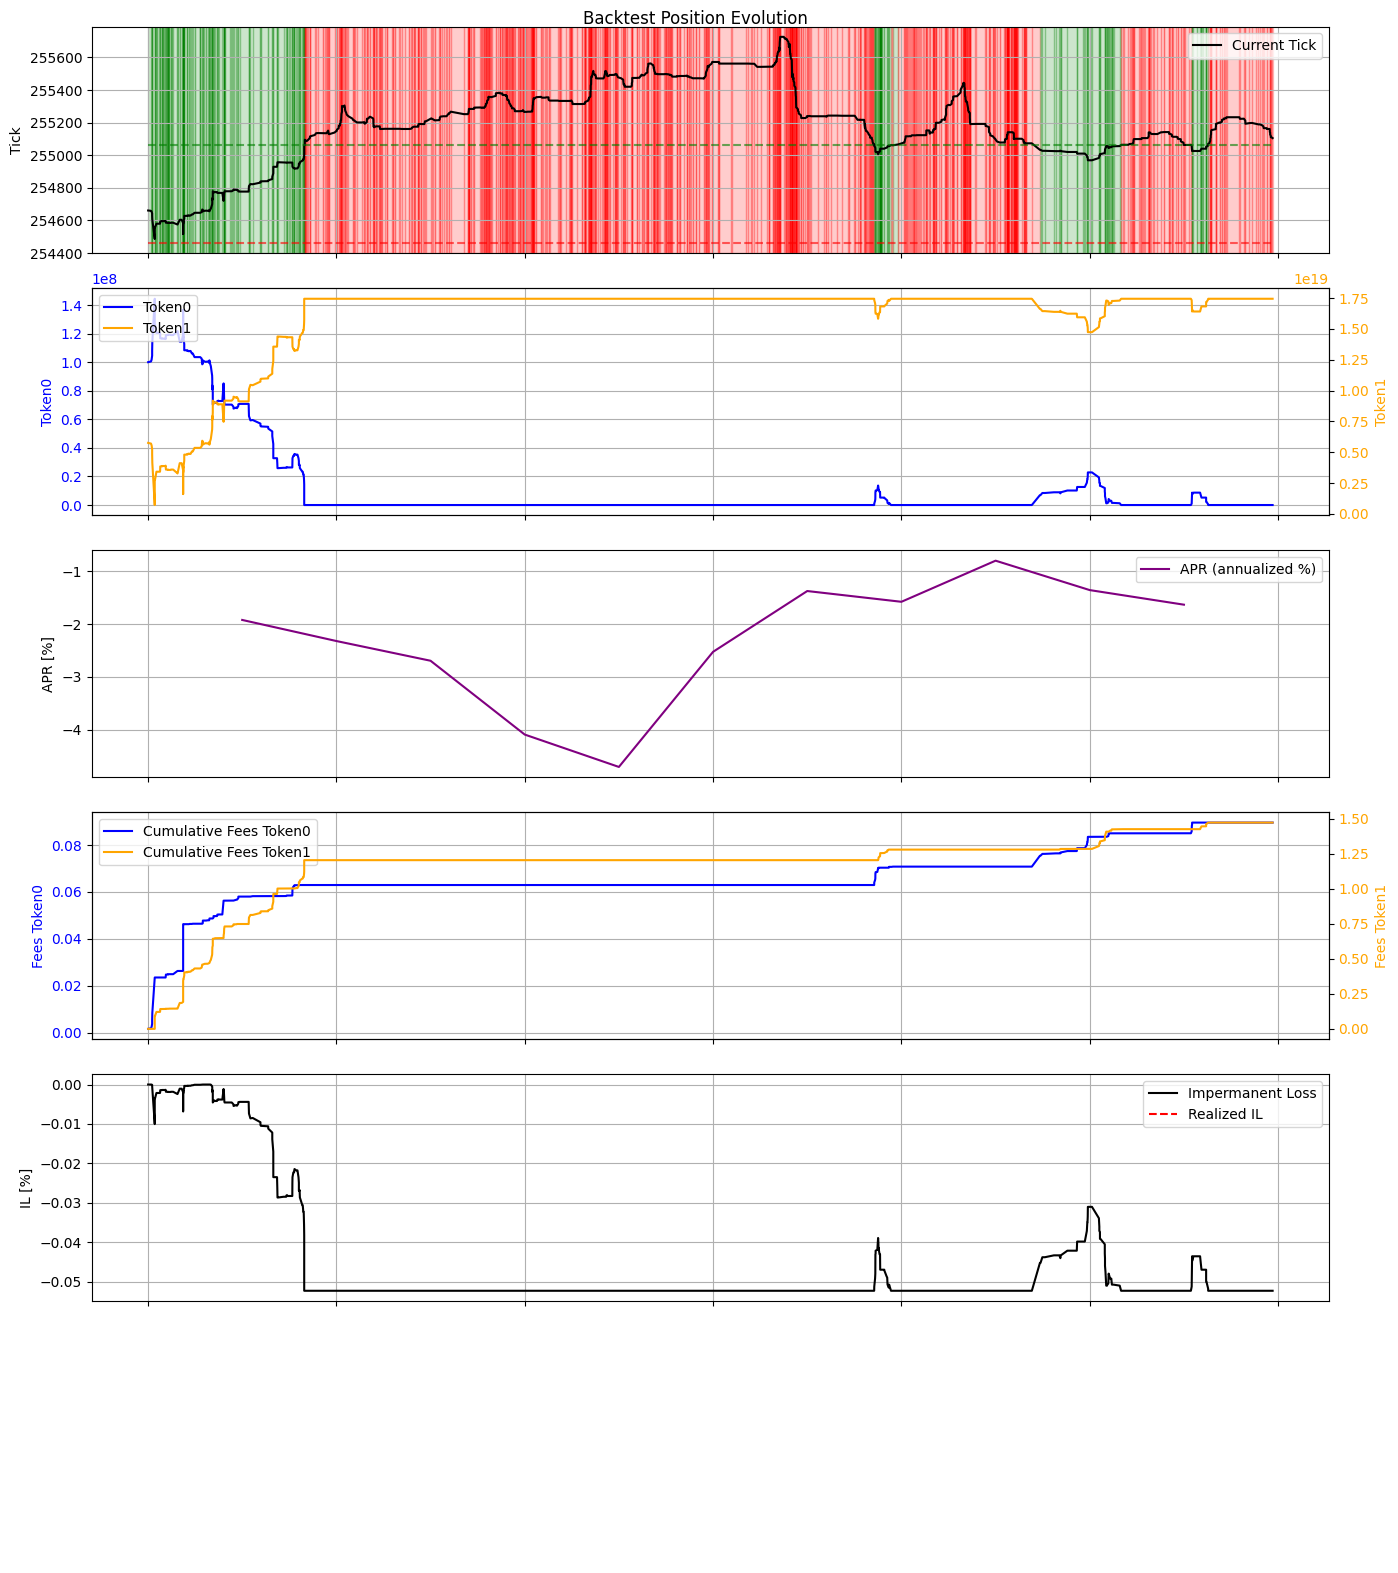

In [6]:
plot_position_evolution(result1)

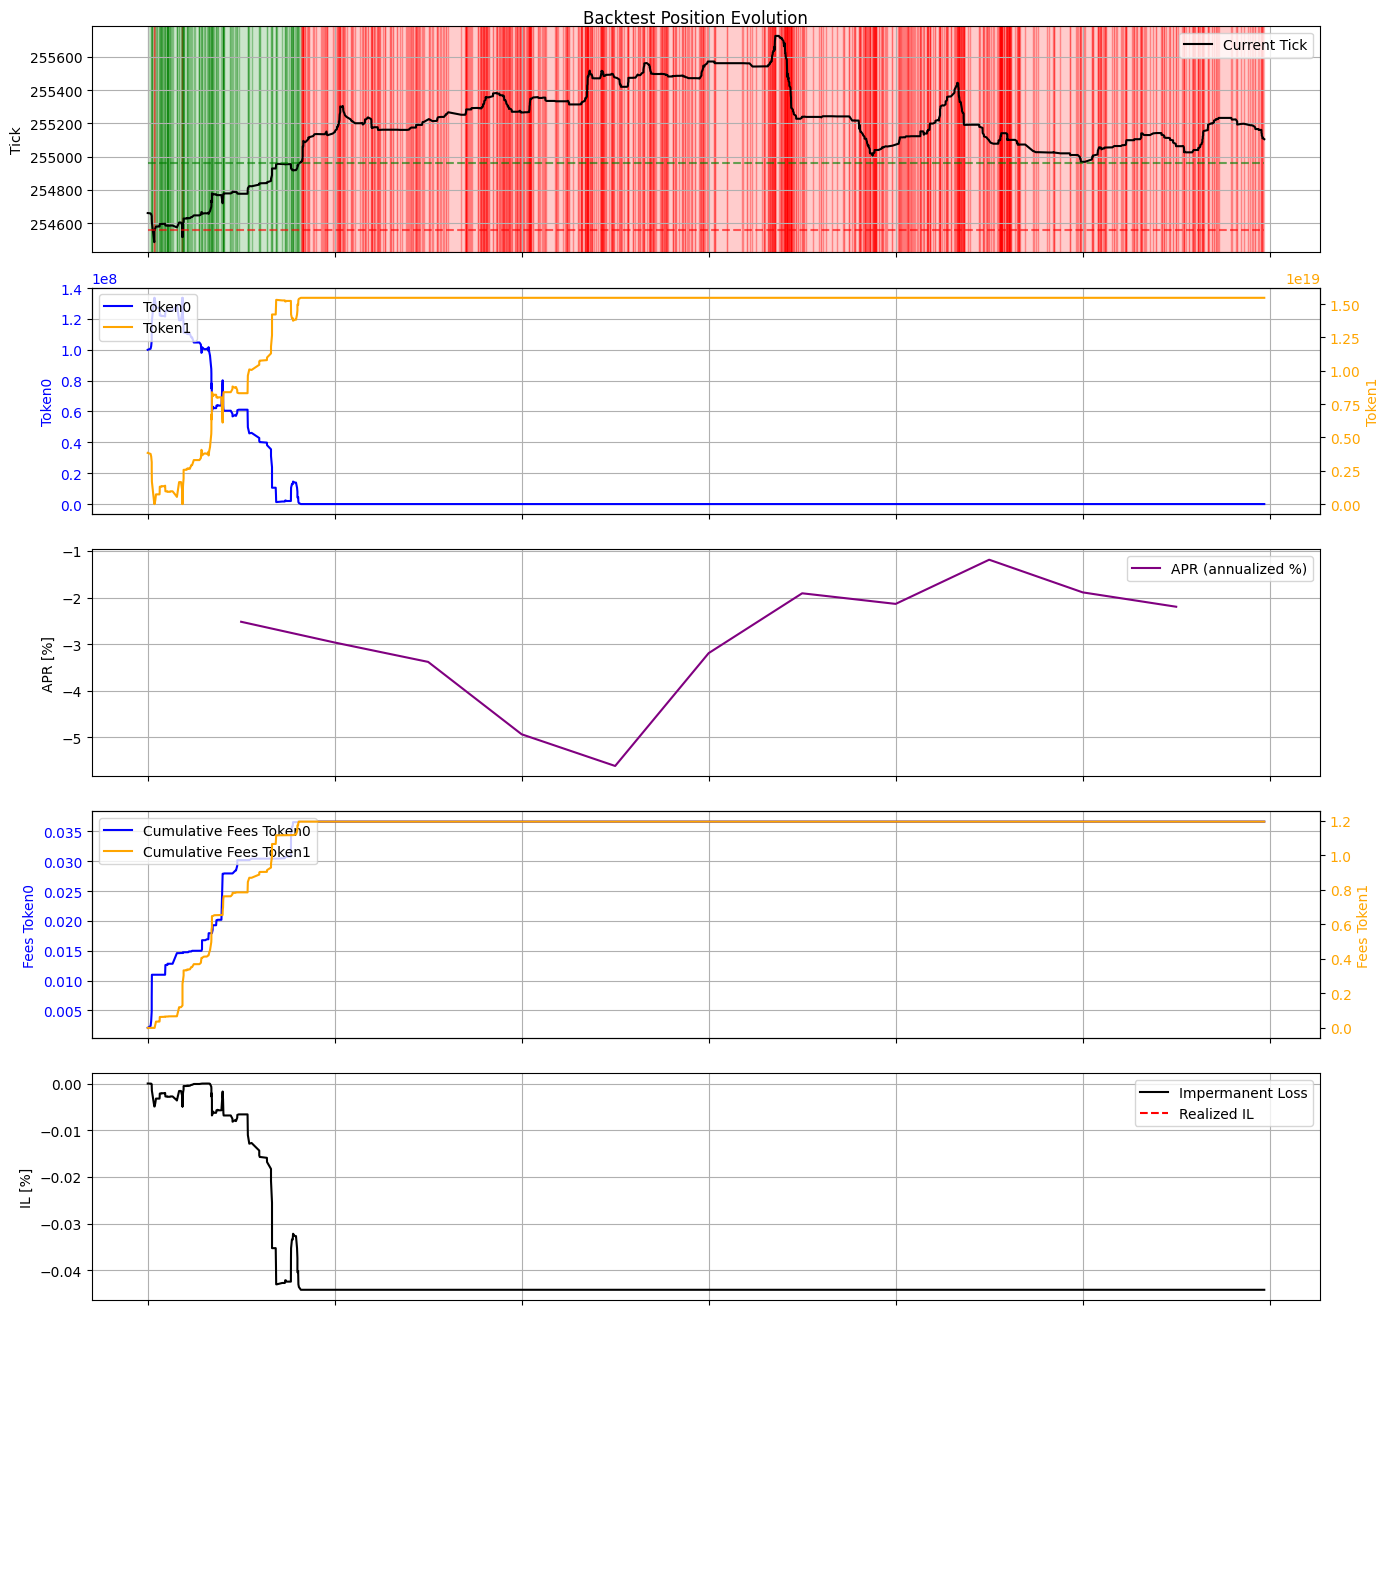

In [7]:
plot_position_evolution(result2)